# Deep Q-Learning Network (DQN)

In this exercise, you will implement a Deep Q-Learning Network (DQN) agent that uses a Neural Network (NN) to estimate the action value (Q value) of a state. Deep Q-Learning Network was invented by Google DeepMind in 2013, and it became famous for achieving superhuman performance on 29 out of 49 games on *Atari 2600* games.

The links to DQN papers are at the end in the **References** section.

## Prerequisites

You are expected to have basic familiarity with Machine Learning, Deep Learning, and Reinforcement Learning, especially on following topics:

 * Neural Network
 * Q-Learning
 * (Optional) Convolutional Neural Network

You are also expected to have basic familarity with PyTorch, especially on following modules:

 * `torch.nn`
 * `torch.optim`

## Environment: CartPole

### OpenAI Gym

First, let's get familiar with the environment we will use to train and validate our DQN agent on. We will use the **CartPole** environment from [OpenAI Gym](https://gym.openai.com). In the CartPole environment, the agent has two components: a cart and a pole.

At every timestep, the agent receives +1 reward unless the episode is terminated. The episode terminates if

 1. the cart is too far left or right
 2. the pole  is too far off from its upright position
 3. 200 timesteps passed.

Thus, the agent's goal is to maintain balance so that the pole stays upright. To maintain balance, the agent must move the cart left or right accordingly. 

![Cartpole](cartpole.gif)

**State Space Dimensions**: 4
 * $x$: Location of the cart
 * $x'$: Speed of the cart
 * $\theta$: Angle of the pole
 * $\theta'$: Angular Speed of the pole

**Action Space Size**: 2
 * Left
 * Right

**Reward**: +1 for all state

To understand the environment a bit better, let's render the environment with a random-action agent.

In [1]:
import gym

To create an environment from OpenAI Gym, we use `gym.make()` command with appropriate environment name. To initialize the environment, we use `env.reset()` command. `env.reset()` returns the observation of the initial state.

In [2]:
env = gym.make('CartPole-v0')
obs = env.reset()
print(obs)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[-0.0004891   0.04477061 -0.04881205  0.02291562]


### Observation Space and Action Space

All OpenAI Gym environment has an `observation_space` attribute and an `action_space` attribute. They help you understand more about the environment.

In [3]:
print('Observation Space: ', env.observation_space)
print('Action Space: ', env.action_space)

Observation Space:  Box(4,)
Action Space:  Discrete(2)


`Box()` and `Discrete()` are spaces defined in OpenAI Gym. `Box(4,)` means that the observation space has dimension of 4, whereas `Discrete(2)` means that the action space has two discrete values. You can retrieve the space dimensions or size with their attributes. The `Box()` space has a `.shape` attribute, and the `Discrete()` space has a `.n` attribute.

In [4]:
print('Observation Space Shape: ', env.observation_space.shape)
print('Action Space Size: ', env.action_space.n)

Observation Space Shape:  (4,)
Action Space Size:  2


The `Discrete()` space also has a `sample()` method. `env.action_space.sample()` returns a randomly selected action.

In [5]:
action = env.action_space.sample()
print(action)

0


### Perform an Action

To perform an action, we use `env.step(action)`. The environment then returns `(obs, rew, done, info)`, where
 * `obs` is the observation of the state after the action
 * `rew` is the reward after the action
 * `done` is a boolean indicating if the episode has terminated
 * `info` is a dictionary containing other useful information about the environment

In [6]:
action = env.action_space.sample()
obs, rew, done, info = env.step(action)
print('Observation: ', obs)
print('Reward: ', rew)
print('Done: ', done)
print('Info: ', info)

Observation:  [ 0.00040631  0.24055736 -0.04835374 -0.28475975]
Reward:  1.0
Done:  False
Info:  {}


To render the environment, we use `env.render()`, and to close the rendered window, we use `env.close()`.

In [7]:
done = False
while not done:
    action = env.action_space.sample()
    obs, rew, done, info = env.step(action)
    env.render()
env.close()

## Naive DQN Agent

In this section, we will implement a naive version of a Deep Q-Learning Network. The idea is simple: transform a tabular Q-Learning algorithm into a approximate Q-Learning algorithm by simply using a neural network to approximate the action value.

As a refresher, here is the tabular Q-Learning algorithm:

$$ Q(s, a) := Q(s, a) + \alpha \big(r + \gamma \max_{a'} Q(s', a') - Q(s, a) \big) $$

### Neural Network

Let's implement a neural network with PyTorch. We will use a simple neural network with few layers.

In [8]:
import torch
import torch.nn as nn

We create a `DQN` class that inherits `torch.nn.Module`. Let's define the layers in `DQN.__init__()` and define the forward propagation step in `DQN.forward()`.

In [9]:
class DQN(nn.Module):

    def __init__(self, input_dims, output_dims):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dims)
        )

    def forward(self, x):
        return self.layers(x)

Let's make sure that the `DQN` is working properly by giving a zero vector as input. We will use the observation given by the environment as our state.

In [10]:
dqn = DQN(env.observation_space.shape[0], env.action_space.n)
dqn.forward(torch.zeros(4))

tensor([ 0.0567,  0.1045])

### Choose Action

We first define `act()` that chooses an action using the DQN with an epsilon-greedy policy.

In [11]:
import random

In [12]:
def act(state, epsilon):
    """
    Return an action with respect to the epsilon-greedy policy.

    Parameters
    ----------
    state : list of float
        The current state given by the environment.
    epsilon : float
        The possibility of selecting a random action.

    Returns
    -------
    action : int
        The action chosen by the agent.
    """
    if random.random() > epsilon:
        state = torch.FloatTensor(state)
        q_value = dqn.forward(state)
        action = int(q_value.argmax())
    else:
        action = env.action_space.sample()

    return action

Let's test the `act()` function. We use the the initial observation from `env.reset()` as our state.

In [13]:
state = env.reset()
greedy_action = act(state, 0)
random_action = act(state, 1)
print('Greedy action: ', greedy_action)
print('Random action: ', random_action)

Greedy action:  1
Random action:  0


Awesome! We now have an agent that can use DQN to choose an action.

### Loss Function

In Supervised Learning, every data in the training set had a **label** $y$ that represented the correct answer. Therefore, we could calculate the loss by comparing the prediction $\hat{y}$ and $y$:

$$ \text{MSE} = (\hat{y} - y)^2 $$

In Reinforcement Learning, the agent does not know the correct action value $Q(s, a)$. Thus, in Q-Learning, we use the bootstrapped **target** instead.

$$ \text{MSE} = (r + \gamma\max_{a'}(Q(s', a') - Q(s, a))^2 $$

In [14]:
discount_factor = 0.9

In [15]:
def compute_loss(state, action, reward, next_state, done):
    """
    Compute the MSE loss given a transition (s, a, r, s').
    
    Parameters
    ----------
    state : list of float
        The current state s given by the environment.
    action : int
        Action a chosen by the agent.
    reward : float
        Reward given by the environment for given state s and action a.
    next_state : list of float
        The resulting state s' after taking action a on state s.
    done: bool
        True if s' is a terminal state. False otherwise.

    Returns
    -------
    loss : torch.tensor
        The MSE loss of the DQN.
    """
    state = torch.FloatTensor(state)
    q_values = dqn(state)
    q_value = q_values[action]

    next_state = torch.FloatTensor(next_state)
    next_q_values = dqn(next_state)
    next_q_value = next_q_values.max()

    if done:
        target = reward
    else:
        target = reward + discount_factor * next_q_value

    loss = (q_value - target).pow(2).mean()

    return loss

In [16]:
action = act(state, epsilon=1)
next_state, reward, done, _ = env.step(action)
loss = compute_loss(state, action, reward, next_state, done)
print('MSE Loss: ', loss)

MSE Loss:  tensor(1.0430)


### Optimizer

`PyTorch` has multiple optimizers in `torch.optim` module.

In [17]:
import torch.optim as optim

We will use the Adam optimizer `torch.optim.Adam()`. To create an optimizer, we call `torch.optim.Adam()` with the parameters of the neural network.

In [18]:
optimizer = optim.Adam(dqn.parameters())

Calling `.backward()` on a tensor calculates the gradients. `optimizer.step()` uses the gradients to update the parameters of the network.

In [19]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

### Train Agent

Training the model is simple: for every step, we compute the loss with `compute_loss` and perform Stochastic Gradient Descent (SGD) with `optimizer`.

To understand the agent's performance during training, we will use `matplotlib` to plot the episode reward and MSE loss while the agent is being trained.

In [20]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [21]:
def plot(step, rewards, losses):
    """
    Plot the total episode rewards and losses per timestep.

    Parameters
    ----------
    rewards : list of float
        List of total rewards for each episode.
    losses : list of float
        List of losses for each timestep.
    """
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Total Episode Reward')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('MSE Loss')
    plt.plot(losses)
    plt.show()

In [22]:
def train(n_steps=1000, show=False):
    """
    Train the agent for specified number of steps.
    
    Parameters
    ----------
    n_steps : int
        Number of timesteps to train the agent for.
    show : bool
        If True, plots the episode rewards and losses on Jupyter Notebook.
    """
    epsilon = 0.1
    state = env.reset()
    done = False
    episode_rewards = []
    episode_reward = 0
    losses = []
    for step_i in range(n_steps):
        action = act(state, epsilon)
        next_state, reward, done, _  = env.step(action)
        episode_reward += reward

        optimizer.zero_grad()
        loss = compute_loss(state, action, reward, next_state, done)
        losses.append(loss)
        loss.backward()
        optimizer.step()

        if done:
            state = env.reset()
            episode_rewards.append(episode_reward)
            episode_reward = 0
        else:
            state = next_state
            
        if step_i % 200 == 0 and show:
            plot(step_i, episode_rewards, losses)

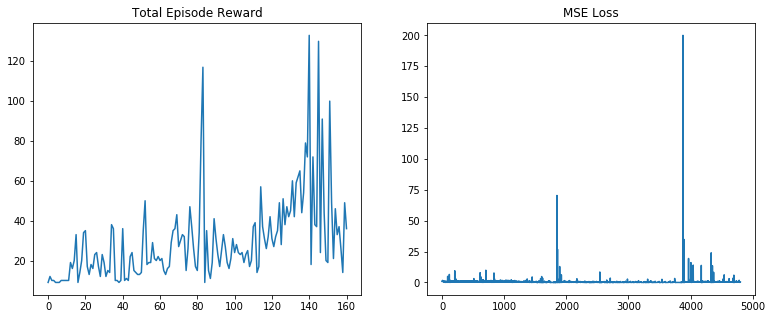

In [23]:
train(5000, show=True)

### Play

Let's see how good the trained agent is.

In [24]:
def play():
    """
    Play an episode and return the total reward for the episode.
    """
    total_reward = 0
    state = env.reset()
    done = False

    while not done:
        action = act(state, epsilon=0)
        next_state, reward, done, _  = env.step(action)
        env.render()
        total_reward += reward
        state = next_state

    return total_reward    

In [25]:
env = gym.make('CartPole-v0')
for i in range(5):
    print('Total reward: ', play())
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total reward:  31.0
Total reward:  34.0
Total reward:  31.0
Total reward:  30.0
Total reward:  31.0


The maximum total reward for each episode is $200.0$.

## Improvements

Although the Naive DQN worked decently for `CartPole` environment, it performs poorly in more complex environments like *Atari 2600* due to its instability. To alleviate these problems, the following improvements are made to the naive DQN:

 * Experience Replay (Mnih, 2013)
 * Target Network (Mnih, 2015)
 * Huber Loss (Mnih, 2015)

### Experience Replay

In Q-Learning, the agent only looks at each experience once: after taking an action, it uses the experience $(s, a, r, s')$ once and forgets it immediately after the update. **Experience Replay** considers a different approach: the agent remembers the last $D$ experiences by saving them into a "replay memory". Also, instead of updating the parameters with the new experience, the agent updates its parameters by sampling a batch from the replay memory.

This approach has several advantages:

 1. Every experience is used multiple times, so it is more efficient in terms of data.
 2. Experiences are strongly correlated in the Naive DQN. Randomly sampling from replay memory breaks these correlations and thus reduces the variance of the updates.

First, let's create a `ReplayBuffer` class. The `ReplayBuffer` needs two functions:

 * `ReplayBuffer.add_sample()` that appends the new experience
 * `ReplayBuffer.sample()` that uniformly samples a batch of experiences from the buffer

We will use Python's `deque` (pronounced "deck", not "dequeue").

In [26]:
from collections import deque

In [27]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add_sample(self, state, action, reward, next_state, done):
        """
        Add given experience as sample.
        """
        deque.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Return a batch of samples.
        """
        return random.sample(deque, batch_size)

### Target Network

**Target Network** $\hat{Q}$ is a method of using a separate network to generate the target $r + \gamma \max_{a'} \hat{Q}(s', a')$. The target network $\hat{Q}$ is updated periodically by cloning the parameters of the original network $Q$.

### Huber Loss

**Huber loss** is a simple clipping done to the error term $r + \gamma \max_a' \hat{Q}(s', a') - Q(s, a)$. 

### `DQNAgent` class

Adding the three modifications (Experience Replay, Target Network, Huber Loss) makes our DQN complete: we have implemented all the algorithms specified in the papers *Playing Atari with Deep Reinforcement Learning* (2013) and *Human-level control through deep reinforcement learning (2015)*.

Let's now create a `DQNAgent` class that utilizes these modifications and test it on the `CartPole` environment to compare it with our `NaiveDQNAgent` implementation.

## Optional Environment: Pong

In the DQN paper by Google DeepMind, they tested their agents with games from *Atari 2600*. We can also try training and evaluating the DQN agent's performance on *Atari 2600* games. Specifically, we will use *Pong* as our environment.

![](pong.jpg)

**State Space Dimensions**: (210, 160, 3)
 * Height of 210 pixels
 * Width of 160 pixels
 * Pixels represented by RGB values: 3 numbers ranging from 0~255

**Action Space Size**: 6

In [28]:
env = gym.make('PongNoFrameskip-v4')
obs = env.reset()
print(obs.shape)

(210, 160, 3)


In [29]:
print(env.action_space.n)

6


## Optional Agent: CNN DQN

Unlike CartPole, the observation we receive from the environment is an image of shape (210, 160, 3). Thus, we should use a Convolutional Neural Network (CNN) in the DQN.

In [30]:
class CNNDQN(nn.Module):
    def __init__(self, input_dims, output_dims):
        pass

    def forward(self, x):
        pass

    def act(self, state, epsilon):
        pass

## References

### Papers

 * [Playing Atari with Deep Reinforcement Learning (2013)](https://arxiv.org/pdf/1312.5602.pdf)
 * [Human-level control through deep reinforcement learning (2015)](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf)

### Code

 * [PyTorch: Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
 * [RL Adventure by higgsfield](https://github.com/higgsfield/RL-Adventure)